In [49]:
#%%writefile /home/sam/gecode-5.0.0-extension/analysis/utils.py

#%load /home/sam/gecode-5.0.0-extension/analysis/utils.py
#%%writefile /home/sam/gecode-5.0.0-extension/analysis/utils.py
from sklearn.linear_model import LogisticRegressionCV

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from io import StringIO
%matplotlib inline

def get_node_in_exs(exs, path_db):
    req_sql = """
        SELECT d.*,
          CASE WHEN r.exec_id IS NOT NULL THEN 1 ELSE 0 END as in_sol
        FROM densities AS d
        LEFT JOIN results AS r
          ON d.exec_id=r.exec_id
          AND d.var_id=r.var_id
          AND d.val=r.val
        WHERE d.exec_id = $2;
    """

    df = pd.DataFrame()
    for ex in exs:
        req_sql_ex = req_sql.replace('$2', str(ex))
        output = !sqlite3 -header -csv {path_db} "{req_sql_ex}"
        if len(output) == 0: continue
        df = df.append(
            pd.read_csv(
                StringIO(output.n),
                index_col=['exec_id','node_id','var_id','val']
            )
        )
    return df

def get_node_in_exs_old_db(exs, path_db, sat=True):
    req_sql = """
        SELECT d.*,
          n.sat,
          CASE WHEN r.exec_id IS NOT NULL THEN 1 ELSE 0 END as in_sol
        FROM densities AS d
        JOIN nodes AS n
          ON d.exec_id=n.exec_id
          AND d.node_id=n.node_id
          $1
        LEFT JOIN results AS r
          ON d.exec_id=r.exec_id
          AND d.var_idx=r.var_idx
          AND d.val=r.val
          AND r.res_id=0 -- TEMPORAIRE
        WHERE d.exec_id = $2
           AND EXISTS (
             SELECT exec_id
             FROM results as rr
             WHERE rr.exec_id = $2
        );
    """
    
    if sat:
        req_sql = req_sql.replace('$1',"AND n.sat=1")
        
    df = pd.DataFrame()
    for ex in exs:
        req_sql_ex = req_sql.replace('$2', str(ex))
        output = !sqlite3 -header -csv {path_db} "{req_sql_ex}"
        if len(output) == 0:continue
        df = df.append(
            pd.read_csv(
                StringIO(output.n),
                index_col=['exec_id','node_id','prop_id','var_idx','val']
            )
        )
        
    return df

def get_node_in_exs_2runs(path_db, exs=[]):
    req_sql = """
        SELECT d.*,
            CASE WHEN r.exec_id IS NOT NULL THEN 1 ELSE 0 END as in_sol
        FROM densities AS d
        LEFT JOIN results AS r
            ON d.exec_id=r.exec_id
            AND d.var_id=r.var_id
            AND d.val=r.val
    """

    if len(exs) != 0:
        _exs = ""
        for x in exs:
            _exs += str(x) + ','
        _exs = _exs[:-1]
        req_sql += " WHERE exec_id in (" + _exs + ")"

    output = !sqlite3 -header -csv {path_db} "{req_sql}"
    return pd.read_csv(
        StringIO(output.n),
        index_col=['exec_id','node_id','prop_id','var_id','val']
    )

features_subset = [
    "max_sd",
    "a_avg_sd"
]

def plot_features_sln_sep(features):
    width = 3
    height = math.ceil(len(features)/width)
    plt.figure(figsize=(16,4*height))

    for i, feature in enumerate(features):
        plt.subplot(width,height, i+1)
        plt.title(feature)
        sns.kdeplot(df[df.in_sol == False][feature], color='r')
        sns.kdeplot(df[df.in_sol == True][feature], color='g')
        plt.gca().legend_.remove()
        plt.ylim(0,10)
        
def get_X_y(df):
    return df.iloc[:,:-1], df.iloc[:,-1]

# TEMP
def print_coefs(clf, features):
    print('double _x = 0;')
    for i, coef in enumerate(clf.coef_[0]):
         print("_x += %.4f * %s;" % (coef, features[i][1]))
    print('double intercept = %.4f;' % (clf.intercept_))
    print('_x += intercept;')

# TEMP

def solved_graph(df, xcol, xlabel="", heur_to_plot=[]):
    if heur_to_plot == []:
        heur_to_plot = df.reset_index()['heur'].unique()
    for heur in heur_to_plot:
        x = df.loc[heur].dropna().sort_values(by=xcol)[xcol].values
        y = [i/len(x)*100 for i,_ in enumerate(x)]


        plt.plot(x,y, label=heur, linewidth=3)
        plt.xscale('log')

    if xlabel != "" : plt.xlabel(xlabel)
    else: plt.xlabel(xcol)
    plt.ylabel('% Solved')
    plt.ylim(0,100)

    plt.legend(loc='lower right')
    
def failures_time_solved(path, title,**kwargs):
    df = pd.read_csv(path, sep=' ', names=['heur', 'ex', 'failures', 'time'])
    df = df.replace(-1, np.nan)
    df = df.set_index(['heur', 'ex'])

    plt.figure(figsize=(16,7))
    plt.suptitle(title)
    plt.subplot(1,2,1)
    solved_graph(df, 'failures', 'Number of failures', **kwargs)
    plt.subplot(1,2,2)
    solved_graph(df, 'time', 'Time (ms)', **kwargs)

In [36]:
end_title=' executions with 10^6 failures cutoff'

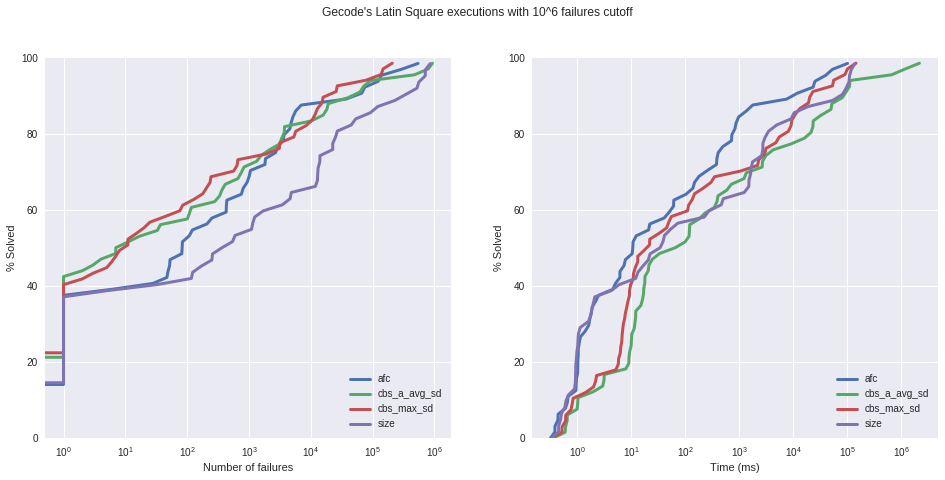

In [43]:
def failures_ls(heur_to_plot):
    failures_time_solved(
        './results_graph_gecode/results_qcp', 
        'Gecode\'s Latin Square' + end_title, 
        heur_to_plot=heur_to_plot
    )
    
failures_ls(['afc', 'cbs_a_avg_sd', 'cbs_max_sd', 'size'])

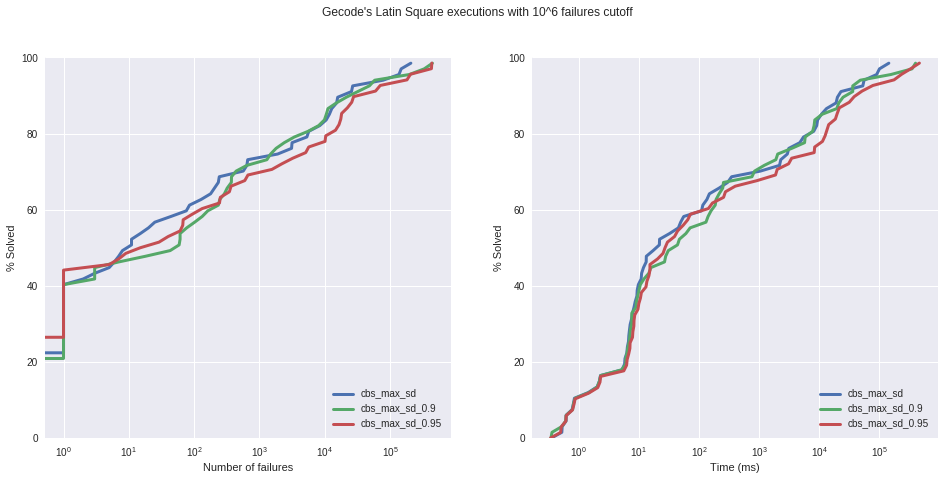

In [47]:
failures_ls(['cbs_max_sd', 'cbs_max_sd_0.9', 'cbs_max_sd_0.95'])